In [1]:
!pip install torch torchvision tensorboard tqdm matplotlib numpy

In [2]:
from models.DCGAN import DCGAN
import torch
import torch.nn as nn
import torch.optim as optim
import os
import shutil
import random
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# Set random seeds for reproducibility
SEED = 999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Training function for GAN
def train_gan_model(model, dataloader, num_epochs, device, model_name, logger=None, save_best=True, denorm_params=None):
    model.to(device)
    best_generator_loss = float('inf')

    os.makedirs('../checkpoints', exist_ok=True)
    os.makedirs(f'../logs/{model_name}', exist_ok=True)
    
    writer = SummaryWriter(log_dir=f'logs/{model_name}') if logger is None else logger

    for epoch in range(num_epochs):
        model.netG.train()
        model.netD.train()
        epoch_loss_G = 0.0
        epoch_loss_D = 0.0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, data in enumerate(progress_bar):
            # Perform training step
            losses, fake_imgs = model.loss_function(data, device)

            # Accumulate losses
            epoch_loss_D += losses['errD']
            epoch_loss_G += losses['errG']

            # Logging
            if i % 100 == 0:
                step = epoch * len(dataloader) + i
                writer.add_scalar('Loss/Discriminator', losses['errD'], step)
                writer.add_scalar('Loss/Generator', losses['errG'], step)
                writer.add_scalar('D(x)', losses['D_x'], step)
                writer.add_scalar('D(G(z))_before', losses['D_G_z1'], step)
                writer.add_scalar('D(G(z))_after', losses['D_G_z2'], step)

                progress_bar.set_postfix({
                    'Loss_D': losses['errD'],
                    'Loss_G': losses['errG'],
                    'D(x)': losses['D_x'],
                    'D(G(z))': f"{losses['D_G_z1']:.4f}/{losses['D_G_z2']:.4f}"
                })

        avg_loss_D = epoch_loss_D / len(dataloader)
        avg_loss_G = epoch_loss_G / len(dataloader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss_D: {avg_loss_D:.4f}, Loss_G: {avg_loss_G:.4f}')

        generated_images = model.generate_images(device=device)
        save_generated_images(generated_images, epoch, model_name, writer, denorm_params)

        if save_best and avg_loss_G < best_generator_loss:
            best_generator_loss = avg_loss_G
            torch.save(model.netG.state_dict(), f'checkpoints/{model_name}_netG_best.pth')
            print(f'Best Generator model saved with loss: {best_generator_loss:.6f}')

        torch.save(model.netG.state_dict(), f'checkpoints/{model_name}_netG_epoch_{epoch+1}.pth')
        torch.save(model.netD.state_dict(), f'checkpoints/{model_name}_netD_epoch_{epoch+1}.pth')

    writer.close()

# Function to save generated images
def save_generated_images(fake_images, epoch, model_name, writer, denorm_params=None):
    if denorm_params is not None:
        # Denormalize images for visualization
        mean = torch.tensor(denorm_params['mean']).view(1, -1, 1, 1)
        std = torch.tensor(denorm_params['std']).view(1, -1, 1, 1)
        fake_images = fake_images * std + mean

    # Clamp images to [0, 1]
    fake_images = torch.clamp(fake_images, 0, 1)

    # Make a grid of images
    img_grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=False)
    writer.add_image('Generated Images', img_grid, epoch+1)
    # Optionally save the image to disk
    os.makedirs(f'images/{model_name}', exist_ok=True)
    torchvision.utils.save_image(img_grid, f'images/{model_name}/generated_epoch_{epoch+1}.png')
    print(f'Saved generated images to images/{model_name}/generated_epoch_{epoch+1}.png')

def get_dataloader(batch_size=128, image_size=32, shuffle=True, num_workers=2):
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    ])

   
    denorm_params = {
        'mean': [0.5],
        'std': [0.5],
    }

    # Download and load the dataset
    dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return dataloader, denorm_params

# Parameters
ngpu = 1
nz = 100
ngf = 64
ndf = 64
nc = 3  # Number of channels
num_epochs = 70
batch_size = 64
image_size = 32
model_name = 'dcgan'
lr = 0.0002
beta1 = 0.5

    # Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

    # Data loader
dataloader, denorm_params = get_dataloader(batch_size=batch_size, image_size=image_size)

    # Instantiate the DCGAN model
model = DCGAN(ngpu, nz, ngf, ndf, nc)

    # Optimizers
optimizerD = optim.Adam(model.netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(model.netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Set optimizers in the model
model.set_optimizers(optimizerD, optimizerG)

    # Train the model
train_gan_model(
        model,
        dataloader,
        num_epochs,
        device,
        model_name=model_name,
        denorm_params=denorm_params
    )


Using device: cuda


100%|██████████| 170M/170M [00:02<00:00, 60.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Epoch 1/70: 100%|██████████| 782/782 [00:09<00:00, 82.88it/s, Loss_D=0.559, Loss_G=3.07, D(x)=0.706, D(G(z))=0.0970/0.0777] 


Epoch [1/70], Loss_D: 0.4127, Loss_G: 4.6671
Saved generated images to images/dcgan/generated_epoch_1.png
Best Generator model saved with loss: 4.667052


Epoch 2/70: 100%|██████████| 782/782 [00:08<00:00, 97.70it/s, Loss_D=1.23, Loss_G=7.14, D(x)=0.881, D(G(z))=0.5526/0.0014] 


Epoch [2/70], Loss_D: 0.4754, Loss_G: 3.4076
Saved generated images to images/dcgan/generated_epoch_2.png
Best Generator model saved with loss: 3.407609


Epoch 3/70: 100%|██████████| 782/782 [00:07<00:00, 99.06it/s, Loss_D=0.454, Loss_G=2.7, D(x)=0.874, D(G(z))=0.2476/0.0879] 


Epoch [3/70], Loss_D: 0.5378, Loss_G: 2.9258
Saved generated images to images/dcgan/generated_epoch_3.png
Best Generator model saved with loss: 2.925804


Epoch 4/70: 100%|██████████| 782/782 [00:07<00:00, 100.24it/s, Loss_D=0.844, Loss_G=3.39, D(x)=0.933, D(G(z))=0.5044/0.0436]


Epoch [4/70], Loss_D: 0.6988, Loss_G: 2.5262
Saved generated images to images/dcgan/generated_epoch_4.png
Best Generator model saved with loss: 2.526238


Epoch 5/70: 100%|██████████| 782/782 [00:07<00:00, 98.82it/s, Loss_D=0.663, Loss_G=3.35, D(x)=0.916, D(G(z))=0.4036/0.0463] 


Epoch [5/70], Loss_D: 0.6953, Loss_G: 2.4606
Saved generated images to images/dcgan/generated_epoch_5.png
Best Generator model saved with loss: 2.460625


Epoch 6/70: 100%|██████████| 782/782 [00:07<00:00, 98.51it/s, Loss_D=0.867, Loss_G=1.25, D(x)=0.523, D(G(z))=0.1059/0.3252] 


Epoch [6/70], Loss_D: 0.7029, Loss_G: 2.4132
Saved generated images to images/dcgan/generated_epoch_6.png
Best Generator model saved with loss: 2.413228


Epoch 7/70: 100%|██████████| 782/782 [00:07<00:00, 100.31it/s, Loss_D=0.359, Loss_G=3.51, D(x)=0.889, D(G(z))=0.1983/0.0394]


Epoch [7/70], Loss_D: 0.6850, Loss_G: 2.4073
Saved generated images to images/dcgan/generated_epoch_7.png
Best Generator model saved with loss: 2.407261


Epoch 8/70: 100%|██████████| 782/782 [00:07<00:00, 100.58it/s, Loss_D=0.584, Loss_G=2.56, D(x)=0.786, D(G(z))=0.2502/0.1038]


Epoch [8/70], Loss_D: 0.6686, Loss_G: 2.4015
Saved generated images to images/dcgan/generated_epoch_8.png
Best Generator model saved with loss: 2.401517


Epoch 9/70: 100%|██████████| 782/782 [00:07<00:00, 99.48it/s, Loss_D=1.27, Loss_G=0.927, D(x)=0.38, D(G(z))=0.0896/0.4263] 


Epoch [9/70], Loss_D: 0.7401, Loss_G: 2.3186
Saved generated images to images/dcgan/generated_epoch_9.png
Best Generator model saved with loss: 2.318557


Epoch 10/70: 100%|██████████| 782/782 [00:07<00:00, 100.28it/s, Loss_D=1.37, Loss_G=4.64, D(x)=0.845, D(G(z))=0.6353/0.0142]


Epoch [10/70], Loss_D: 0.6960, Loss_G: 2.3283
Saved generated images to images/dcgan/generated_epoch_10.png


Epoch 11/70: 100%|██████████| 782/782 [00:07<00:00, 99.99it/s, Loss_D=0.714, Loss_G=1.8, D(x)=0.655, D(G(z))=0.2001/0.1985] 


Epoch [11/70], Loss_D: 0.7264, Loss_G: 2.2672
Saved generated images to images/dcgan/generated_epoch_11.png
Best Generator model saved with loss: 2.267222


Epoch 12/70: 100%|██████████| 782/782 [00:07<00:00, 98.47it/s, Loss_D=1.22, Loss_G=3.95, D(x)=0.896, D(G(z))=0.6147/0.0284] 


Epoch [12/70], Loss_D: 0.7000, Loss_G: 2.3210
Saved generated images to images/dcgan/generated_epoch_12.png


Epoch 13/70: 100%|██████████| 782/782 [00:07<00:00, 99.51it/s, Loss_D=0.475, Loss_G=2.02, D(x)=0.803, D(G(z))=0.2016/0.1602] 


Epoch [13/70], Loss_D: 0.7217, Loss_G: 2.2758
Saved generated images to images/dcgan/generated_epoch_13.png


Epoch 14/70: 100%|██████████| 782/782 [00:07<00:00, 98.99it/s, Loss_D=1.09, Loss_G=1.49, D(x)=0.515, D(G(z))=0.2228/0.2816] 


Epoch [14/70], Loss_D: 0.7096, Loss_G: 2.2904
Saved generated images to images/dcgan/generated_epoch_14.png


Epoch 15/70: 100%|██████████| 782/782 [00:07<00:00, 99.94it/s, Loss_D=0.742, Loss_G=2.09, D(x)=0.651, D(G(z))=0.1950/0.1748] 


Epoch [15/70], Loss_D: 0.6786, Loss_G: 2.3350
Saved generated images to images/dcgan/generated_epoch_15.png


Epoch 16/70: 100%|██████████| 782/782 [00:07<00:00, 102.46it/s, Loss_D=0.278, Loss_G=2.81, D(x)=0.835, D(G(z))=0.0735/0.0813]


Epoch [16/70], Loss_D: 0.7005, Loss_G: 2.3422
Saved generated images to images/dcgan/generated_epoch_16.png


Epoch 17/70: 100%|██████████| 782/782 [00:07<00:00, 99.07it/s, Loss_D=0.942, Loss_G=1.27, D(x)=0.5, D(G(z))=0.1041/0.3442] 


Epoch [17/70], Loss_D: 0.6794, Loss_G: 2.3754
Saved generated images to images/dcgan/generated_epoch_17.png


Epoch 18/70: 100%|██████████| 782/782 [00:07<00:00, 98.46it/s, Loss_D=0.826, Loss_G=2.37, D(x)=0.766, D(G(z))=0.3750/0.1173] 


Epoch [18/70], Loss_D: 0.6898, Loss_G: 2.3606
Saved generated images to images/dcgan/generated_epoch_18.png


Epoch 19/70: 100%|██████████| 782/782 [00:07<00:00, 100.97it/s, Loss_D=1.09, Loss_G=0.199, D(x)=0.418, D(G(z))=0.0525/0.8463]


Epoch [19/70], Loss_D: 0.6939, Loss_G: 2.3904
Saved generated images to images/dcgan/generated_epoch_19.png


Epoch 20/70: 100%|██████████| 782/782 [00:07<00:00, 99.42it/s, Loss_D=0.714, Loss_G=3.46, D(x)=0.851, D(G(z))=0.3764/0.0477] 


Epoch [20/70], Loss_D: 0.6536, Loss_G: 2.3996
Saved generated images to images/dcgan/generated_epoch_20.png


Epoch 21/70: 100%|██████████| 782/782 [00:07<00:00, 98.27it/s, Loss_D=0.838, Loss_G=3.25, D(x)=0.857, D(G(z))=0.4183/0.0497] 


Epoch [21/70], Loss_D: 0.6329, Loss_G: 2.4551
Saved generated images to images/dcgan/generated_epoch_21.png


Epoch 22/70: 100%|██████████| 782/782 [00:07<00:00, 101.42it/s, Loss_D=0.441, Loss_G=2.4, D(x)=0.757, D(G(z))=0.1154/0.1197]


Epoch [22/70], Loss_D: 0.6185, Loss_G: 2.5023
Saved generated images to images/dcgan/generated_epoch_22.png


Epoch 23/70: 100%|██████████| 782/782 [00:07<00:00, 99.64it/s, Loss_D=0.446, Loss_G=2.15, D(x)=0.735, D(G(z))=0.1021/0.1491] 


Epoch [23/70], Loss_D: 0.6263, Loss_G: 2.5195
Saved generated images to images/dcgan/generated_epoch_23.png


Epoch 24/70: 100%|██████████| 782/782 [00:07<00:00, 100.10it/s, Loss_D=0.662, Loss_G=1.89, D(x)=0.612, D(G(z))=0.0782/0.2304]


Epoch [24/70], Loss_D: 0.6121, Loss_G: 2.5966
Saved generated images to images/dcgan/generated_epoch_24.png


Epoch 25/70: 100%|██████████| 782/782 [00:07<00:00, 99.23it/s, Loss_D=0.563, Loss_G=2.19, D(x)=0.78, D(G(z))=0.2196/0.1447] 


Epoch [25/70], Loss_D: 0.5981, Loss_G: 2.5950
Saved generated images to images/dcgan/generated_epoch_25.png


Epoch 26/70: 100%|██████████| 782/782 [00:08<00:00, 97.64it/s, Loss_D=0.604, Loss_G=2.42, D(x)=0.774, D(G(z))=0.2482/0.1299]


Epoch [26/70], Loss_D: 0.5720, Loss_G: 2.6603
Saved generated images to images/dcgan/generated_epoch_26.png


Epoch 27/70: 100%|██████████| 782/782 [00:07<00:00, 99.12it/s, Loss_D=0.384, Loss_G=2.6, D(x)=0.751, D(G(z))=0.0593/0.1177] 


Epoch [27/70], Loss_D: 0.5342, Loss_G: 2.7127
Saved generated images to images/dcgan/generated_epoch_27.png


Epoch 28/70: 100%|██████████| 782/782 [00:07<00:00, 101.33it/s, Loss_D=0.335, Loss_G=2.99, D(x)=0.828, D(G(z))=0.1185/0.0807]


Epoch [28/70], Loss_D: 0.5875, Loss_G: 2.7437
Saved generated images to images/dcgan/generated_epoch_28.png


Epoch 29/70: 100%|██████████| 782/782 [00:07<00:00, 98.37it/s, Loss_D=0.368, Loss_G=2.49, D(x)=0.781, D(G(z))=0.0913/0.1152] 


Epoch [29/70], Loss_D: 0.5638, Loss_G: 2.7232
Saved generated images to images/dcgan/generated_epoch_29.png


Epoch 30/70: 100%|██████████| 782/782 [00:07<00:00, 100.62it/s, Loss_D=0.556, Loss_G=4, D(x)=0.944, D(G(z))=0.3390/0.0252]


Epoch [30/70], Loss_D: 0.5427, Loss_G: 2.7665
Saved generated images to images/dcgan/generated_epoch_30.png


Epoch 31/70: 100%|██████████| 782/782 [00:07<00:00, 100.22it/s, Loss_D=0.395, Loss_G=3.33, D(x)=0.883, D(G(z))=0.1969/0.0593]


Epoch [31/70], Loss_D: 0.5368, Loss_G: 2.7775
Saved generated images to images/dcgan/generated_epoch_31.png


Epoch 32/70: 100%|██████████| 782/782 [00:07<00:00, 98.42it/s, Loss_D=0.418, Loss_G=2.91, D(x)=0.886, D(G(z))=0.2094/0.0842]


Epoch [32/70], Loss_D: 0.5311, Loss_G: 2.8721
Saved generated images to images/dcgan/generated_epoch_32.png


Epoch 33/70: 100%|██████████| 782/782 [00:07<00:00, 99.40it/s, Loss_D=0.883, Loss_G=5.48, D(x)=0.968, D(G(z))=0.4998/0.0074]


Epoch [33/70], Loss_D: 0.4788, Loss_G: 2.9446
Saved generated images to images/dcgan/generated_epoch_33.png


Epoch 34/70: 100%|██████████| 782/782 [00:07<00:00, 100.99it/s, Loss_D=0.375, Loss_G=2.7, D(x)=0.872, D(G(z))=0.1824/0.0939]


Epoch [34/70], Loss_D: 0.4779, Loss_G: 2.9897
Saved generated images to images/dcgan/generated_epoch_34.png


Epoch 35/70: 100%|██████████| 782/782 [00:07<00:00, 99.20it/s, Loss_D=0.335, Loss_G=3.27, D(x)=0.917, D(G(z))=0.1975/0.0580] 


Epoch [35/70], Loss_D: 0.5185, Loss_G: 3.0030
Saved generated images to images/dcgan/generated_epoch_35.png


Epoch 36/70: 100%|██████████| 782/782 [00:07<00:00, 100.91it/s, Loss_D=0.37, Loss_G=2.41, D(x)=0.822, D(G(z))=0.1253/0.1298]


Epoch [36/70], Loss_D: 0.4675, Loss_G: 3.0475
Saved generated images to images/dcgan/generated_epoch_36.png


Epoch 37/70: 100%|██████████| 782/782 [00:07<00:00, 100.48it/s, Loss_D=0.154, Loss_G=4.56, D(x)=0.9, D(G(z))=0.0381/0.0201]


Epoch [37/70], Loss_D: 0.4539, Loss_G: 3.0763
Saved generated images to images/dcgan/generated_epoch_37.png


Epoch 38/70: 100%|██████████| 782/782 [00:07<00:00, 99.37it/s, Loss_D=0.421, Loss_G=3.28, D(x)=0.959, D(G(z))=0.2707/0.0591] 


Epoch [38/70], Loss_D: 0.5090, Loss_G: 3.1417
Saved generated images to images/dcgan/generated_epoch_38.png


Epoch 39/70: 100%|██████████| 782/782 [00:07<00:00, 99.38it/s, Loss_D=1.14, Loss_G=0.91, D(x)=0.421, D(G(z))=0.0204/0.5307]


Epoch [39/70], Loss_D: 0.4523, Loss_G: 3.1552
Saved generated images to images/dcgan/generated_epoch_39.png


Epoch 40/70: 100%|██████████| 782/782 [00:07<00:00, 100.76it/s, Loss_D=0.202, Loss_G=3.53, D(x)=0.947, D(G(z))=0.1284/0.0463]


Epoch [40/70], Loss_D: 0.4504, Loss_G: 3.2208
Saved generated images to images/dcgan/generated_epoch_40.png


Epoch 41/70: 100%|██████████| 782/782 [00:07<00:00, 98.38it/s, Loss_D=0.292, Loss_G=2.91, D(x)=0.873, D(G(z))=0.1239/0.0815] 


Epoch [41/70], Loss_D: 0.4645, Loss_G: 3.1533
Saved generated images to images/dcgan/generated_epoch_41.png


Epoch 42/70: 100%|██████████| 782/782 [00:07<00:00, 98.01it/s, Loss_D=0.334, Loss_G=3.64, D(x)=0.952, D(G(z))=0.2184/0.0374]


Epoch [42/70], Loss_D: 0.3942, Loss_G: 3.2916
Saved generated images to images/dcgan/generated_epoch_42.png


Epoch 43/70: 100%|██████████| 782/782 [00:07<00:00, 99.76it/s, Loss_D=0.365, Loss_G=3.3, D(x)=0.943, D(G(z))=0.2258/0.0650] 


Epoch [43/70], Loss_D: 0.4072, Loss_G: 3.3170
Saved generated images to images/dcgan/generated_epoch_43.png


Epoch 44/70: 100%|██████████| 782/782 [00:07<00:00, 98.74it/s, Loss_D=0.309, Loss_G=2.42, D(x)=0.845, D(G(z))=0.1050/0.1317] 


Epoch [44/70], Loss_D: 0.4106, Loss_G: 3.3372
Saved generated images to images/dcgan/generated_epoch_44.png


Epoch 45/70: 100%|██████████| 782/782 [00:07<00:00, 100.13it/s, Loss_D=0.392, Loss_G=3.34, D(x)=0.96, D(G(z))=0.2614/0.0507]


Epoch [45/70], Loss_D: 0.4223, Loss_G: 3.3450
Saved generated images to images/dcgan/generated_epoch_45.png


Epoch 46/70: 100%|██████████| 782/782 [00:07<00:00, 101.12it/s, Loss_D=0.301, Loss_G=3.79, D(x)=0.953, D(G(z))=0.1955/0.0411]


Epoch [46/70], Loss_D: 0.4088, Loss_G: 3.4034
Saved generated images to images/dcgan/generated_epoch_46.png


Epoch 47/70: 100%|██████████| 782/782 [00:07<00:00, 99.04it/s, Loss_D=0.198, Loss_G=3.85, D(x)=0.879, D(G(z))=0.0491/0.0368] 


Epoch [47/70], Loss_D: 0.3742, Loss_G: 3.4748
Saved generated images to images/dcgan/generated_epoch_47.png


Epoch 48/70: 100%|██████████| 782/782 [00:07<00:00, 97.86it/s, Loss_D=0.245, Loss_G=2.92, D(x)=0.848, D(G(z))=0.0600/0.0975]


Epoch [48/70], Loss_D: 0.5209, Loss_G: 3.4341
Saved generated images to images/dcgan/generated_epoch_48.png


Epoch 49/70: 100%|██████████| 782/782 [00:07<00:00, 101.58it/s, Loss_D=0.258, Loss_G=3.77, D(x)=0.898, D(G(z))=0.1134/0.0448]


Epoch [49/70], Loss_D: 0.3587, Loss_G: 3.4122
Saved generated images to images/dcgan/generated_epoch_49.png


Epoch 50/70: 100%|██████████| 782/782 [00:07<00:00, 99.13it/s, Loss_D=0.267, Loss_G=4.23, D(x)=0.986, D(G(z))=0.1863/0.0231]


Epoch [50/70], Loss_D: 0.3799, Loss_G: 3.4866
Saved generated images to images/dcgan/generated_epoch_50.png


Epoch 51/70: 100%|██████████| 782/782 [00:07<00:00, 99.65it/s, Loss_D=0.12, Loss_G=4.04, D(x)=0.949, D(G(z))=0.0606/0.0322]


Epoch [51/70], Loss_D: 0.4164, Loss_G: 3.5569
Saved generated images to images/dcgan/generated_epoch_51.png


Epoch 52/70: 100%|██████████| 782/782 [00:07<00:00, 101.08it/s, Loss_D=0.395, Loss_G=2.55, D(x)=0.827, D(G(z))=0.1405/0.1092]


Epoch [52/70], Loss_D: 0.3595, Loss_G: 3.5755
Saved generated images to images/dcgan/generated_epoch_52.png


Epoch 53/70: 100%|██████████| 782/782 [00:08<00:00, 97.62it/s, Loss_D=0.269, Loss_G=3.51, D(x)=0.865, D(G(z))=0.0796/0.0488] 


Epoch [53/70], Loss_D: 0.5442, Loss_G: 3.6267
Saved generated images to images/dcgan/generated_epoch_53.png


Epoch 54/70: 100%|██████████| 782/782 [00:07<00:00, 99.37it/s, Loss_D=0.394, Loss_G=3.1, D(x)=0.766, D(G(z))=0.0437/0.0834]


Epoch [54/70], Loss_D: 0.3412, Loss_G: 3.4961
Saved generated images to images/dcgan/generated_epoch_54.png


Epoch 55/70: 100%|██████████| 782/782 [00:07<00:00, 101.15it/s, Loss_D=0.334, Loss_G=3.43, D(x)=0.835, D(G(z))=0.1084/0.0513]


Epoch [55/70], Loss_D: 0.3912, Loss_G: 3.6512
Saved generated images to images/dcgan/generated_epoch_55.png


Epoch 56/70: 100%|██████████| 782/782 [00:07<00:00, 99.11it/s, Loss_D=0.26, Loss_G=4.15, D(x)=0.96, D(G(z))=0.1741/0.0283] 


Epoch [56/70], Loss_D: 0.3226, Loss_G: 3.6317
Saved generated images to images/dcgan/generated_epoch_56.png


Epoch 57/70: 100%|██████████| 782/782 [00:07<00:00, 100.20it/s, Loss_D=0.268, Loss_G=4.58, D(x)=0.968, D(G(z))=0.1806/0.0178]


Epoch [57/70], Loss_D: 0.4838, Loss_G: 3.5886
Saved generated images to images/dcgan/generated_epoch_57.png


Epoch 58/70: 100%|██████████| 782/782 [00:07<00:00, 99.94it/s, Loss_D=0.179, Loss_G=3.39, D(x)=0.945, D(G(z))=0.0991/0.0521] 


Epoch [58/70], Loss_D: 0.2693, Loss_G: 3.6712
Saved generated images to images/dcgan/generated_epoch_58.png


Epoch 59/70: 100%|██████████| 782/782 [00:07<00:00, 99.95it/s, Loss_D=0.275, Loss_G=2.98, D(x)=0.834, D(G(z))=0.0543/0.0904] 


Epoch [59/70], Loss_D: 0.3598, Loss_G: 3.7560
Saved generated images to images/dcgan/generated_epoch_59.png


Epoch 60/70: 100%|██████████| 782/782 [00:07<00:00, 100.62it/s, Loss_D=0.304, Loss_G=2.66, D(x)=0.837, D(G(z))=0.0856/0.1401]


Epoch [60/70], Loss_D: 0.3843, Loss_G: 3.7671
Saved generated images to images/dcgan/generated_epoch_60.png


Epoch 61/70: 100%|██████████| 782/782 [00:07<00:00, 103.21it/s, Loss_D=0.0938, Loss_G=3.1, D(x)=0.984, D(G(z))=0.0697/0.0655]


Epoch [61/70], Loss_D: 0.2802, Loss_G: 3.7878
Saved generated images to images/dcgan/generated_epoch_61.png


Epoch 62/70: 100%|██████████| 782/782 [00:07<00:00, 100.66it/s, Loss_D=0.55, Loss_G=5.14, D(x)=0.959, D(G(z))=0.3315/0.0103]


Epoch [62/70], Loss_D: 0.3032, Loss_G: 3.8828
Saved generated images to images/dcgan/generated_epoch_62.png


Epoch 63/70: 100%|██████████| 782/782 [00:07<00:00, 101.26it/s, Loss_D=0.242, Loss_G=3.14, D(x)=0.852, D(G(z))=0.0608/0.0816]


Epoch [63/70], Loss_D: 0.3034, Loss_G: 3.8720
Saved generated images to images/dcgan/generated_epoch_63.png


Epoch 64/70: 100%|██████████| 782/782 [00:07<00:00, 100.84it/s, Loss_D=0.198, Loss_G=4.12, D(x)=0.913, D(G(z))=0.0742/0.0309]


Epoch [64/70], Loss_D: 0.4089, Loss_G: 3.8858
Saved generated images to images/dcgan/generated_epoch_64.png


Epoch 65/70: 100%|██████████| 782/782 [00:07<00:00, 97.86it/s, Loss_D=0.32, Loss_G=3.93, D(x)=0.815, D(G(z))=0.0330/0.0502] 


Epoch [65/70], Loss_D: 0.3030, Loss_G: 3.9521
Saved generated images to images/dcgan/generated_epoch_65.png


Epoch 66/70: 100%|██████████| 782/782 [00:07<00:00, 99.12it/s, Loss_D=0.287, Loss_G=4.31, D(x)=0.801, D(G(z))=0.0141/0.0314]


Epoch [66/70], Loss_D: 0.3440, Loss_G: 3.8450
Saved generated images to images/dcgan/generated_epoch_66.png


Epoch 67/70: 100%|██████████| 782/782 [00:07<00:00, 102.27it/s, Loss_D=0.374, Loss_G=4.06, D(x)=0.94, D(G(z))=0.2168/0.0302]


Epoch [67/70], Loss_D: 0.2873, Loss_G: 3.9367
Saved generated images to images/dcgan/generated_epoch_67.png


Epoch 68/70: 100%|██████████| 782/782 [00:07<00:00, 99.71it/s, Loss_D=0.337, Loss_G=4.04, D(x)=0.786, D(G(z))=0.0300/0.0565]


Epoch [68/70], Loss_D: 0.3036, Loss_G: 3.9982
Saved generated images to images/dcgan/generated_epoch_68.png


Epoch 69/70: 100%|██████████| 782/782 [00:07<00:00, 100.25it/s, Loss_D=0.17, Loss_G=4.68, D(x)=0.984, D(G(z))=0.1203/0.0245]


Epoch [69/70], Loss_D: 0.2873, Loss_G: 3.9907
Saved generated images to images/dcgan/generated_epoch_69.png


Epoch 70/70: 100%|██████████| 782/782 [00:07<00:00, 99.57it/s, Loss_D=0.279, Loss_G=3.8, D(x)=0.883, D(G(z))=0.1047/0.0521] 


Epoch [70/70], Loss_D: 0.3093, Loss_G: 4.0519
Saved generated images to images/dcgan/generated_epoch_70.png


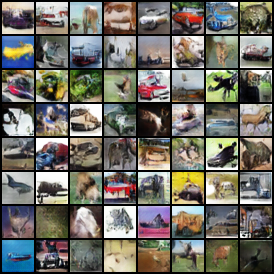

In [3]:
from PIL import Image

image_path = "/content/images/dcgan/generated_epoch_70.png"
image = Image.open(image_path)

image